In [6]:
import json
import pprint
import pickle
from math import log

# dataset source
# https://files.pushshift.io/reddit/comments/
pp = pprint.PrettyPrinter(indent=4)

In [7]:
class RedditThread():
    def __init__(self, link):
        self.body = ""
        self.netScore = 0
        self.link = link
        self.numberOfComments = 0

    def update(self, body, score):
        self.netScore += score
        self.body = self.body + " " + body
        self.numberOfComments += 1

    def concat(self, reddit_thread):
        self.netScore += reddit_thread.netScore
        self.body = self.body + " " + reddit_thread.body
        self.numberOfComments += reddit_thread.numberOfComments

In [9]:
politicsSubreddit = dict()
with open('politics.pkl', 'rb') as politics:
    politicsSubreddit = pickle.load(politics)

In [12]:
# builda dict of thread bodies by link_id

def build_thread_bodies(threads):
    thread_bodies = dict() # link_id: 'str w/ all comment text'
    for link_id in threads.keys():
        thread_bodies[link_id] = threads[link_id].body
            
        # PARSE RULES #
        thread_bodies[link_id] = thread_bodies[link_id].strip()
        thread_bodies[link_id] = thread_bodies[link_id].lower()
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r\n\r\n', ' ')
        thread_bodies[link_id] = thread_bodies[link_id].replace('&gt;', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\n', '')
    return thread_bodies

In [13]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

import numpy as np
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

In [14]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('')

In [15]:
NUM_TOPICS = 10
NUM_WORDS = 5
PASSES = 20

thread_bodies = build_thread_bodies(politicsSubreddit)

# train LDA model

start = time.time()

train = list(thread_bodies.values())
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(train)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(
    n_topics=NUM_TOPICS, 
    max_iter=PASSES, 
    learning_method='online', 
    learning_offset=50., 
    random_state=0
)
lda.fit(tf_train)

display_topics(lda, tf_feature_names, NUM_WORDS)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

/Users/frankchan/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
law speech court rights constitution

Topic 1:
http com www reddit amp

Topic 2:
health care insurance people don

Topic 3:
war people military world just

Topic 4:
people just don like think

Topic 5:
fox news deleted paul conservative

Topic 6:
people just don like think

Topic 7:
obama party vote republicans democrats

Topic 8:
tax money taxes pay government

Topic 9:
people government corporations don think

time elapsed: 184.6763298511505 seconds


In [16]:
test_set = list(thread_bodies.values())
tf_test = tf_vectorizer.fit_transform(test_set)
predict = lda.transform(tf_test)

In [17]:
print('predictions available for {} elements\n'.format(len(predict)))
pp.pprint(predict)

predictions available for 8970 elements

array([[  3.61112955e-04,   2.51541229e-01,   5.42277878e-02, ...,
          2.38890274e-01,   1.46677149e-03,   3.61110265e-04],
       [  8.41956160e-05,   2.23517748e-01,   8.41951202e-05, ...,
          1.47583522e-02,   8.41948160e-05,   8.19244213e-03],
       [  4.22662134e-02,   2.56507499e-04,   2.56462925e-04, ...,
          2.56517561e-04,   2.56478763e-04,   2.56518968e-04],
       ..., 
       [  1.42893350e-02,   1.42920633e-02,   1.42882338e-02, ...,
          1.42888607e-02,   1.42887527e-02,   2.92974422e-01],
       [  2.00022039e-02,   8.19973476e-01,   2.00023793e-02, ...,
          2.00034263e-02,   2.00026254e-02,   2.00024164e-02],
       [  3.33369280e-02,   3.33357393e-02,   3.33374851e-02, ...,
          3.33372939e-02,   3.33367722e-02,   3.33423836e-02]])


In [18]:
# Create matrix that stores cosine distances between predictions
# We use this because we don't care about the length of the vectors
start = time.time()

cos_dist_matrix = cosine_distances(predict, predict)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

time elapsed: 2.3174641132354736 seconds


In [19]:
# Calculate the distance threshold we should use
# Currently std is really high and makes our graph very crowded
# What is a good way to do this
DIST_THRES = np.std(cos_dist_matrix) / 5
print(DIST_THRES)

0.0591891273249


In [20]:
# ASSUMPTION: dict.keys() and dict.values() directly correspond if not modified
# rehydrate node_ids into dist_matrix -> distance lookup table

max_dist = float('-inf')

dist_lookup = { node_id: {} for node_id in thread_bodies.keys() }
for idx1, first in enumerate(list(dist_lookup.keys())):
    for idx2, second in enumerate(list(dist_lookup.keys())):
        dist_lookup[first][second] = 1 if cos_dist_matrix[idx1][idx2] <= DIST_THRES else 0
        max_dist = cos_dist_matrix[idx1][idx2] if cos_dist_matrix[idx1][idx2] > max_dist else max_dist
#         dist_lookup[first][second] = dist_matrix[idx1][idx2] # lazy eval

# check

mistakes = 0
for i in dist_lookup.keys():
    for j in dist_lookup.keys():
        if i==j and dist_lookup[i][j] != 1:
            mistakes += 1
        if dist_lookup[i][j] != dist_lookup[j][i]:
            mistakes += 1

print('max distance seen: {}'.format(max_dist))
print('{} mistakes out of {} entries'.format(mistakes, len(dist_lookup) * len(dist_lookup)))

KeyboardInterrupt: 

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for thread_id in thread_bodies.keys():
    g.add_node(thread_id)

for first in thread_bodies.keys():
    for second in thread_bodies.keys():
        if not g.has_edge(first, second) and dist_lookup[first][second] == 1:
            g.add_edge(first, second)


In [22]:
print(nx.is_connected(g))
degs = nx.degree_histogram(g)
# plt.hist(degs, normed=True, bins=len(degs))
# nx.density(g)
print(nx.info(g))

False
Name: 
Type: Graph
Number of nodes: 8970
Number of edges: 1750104
Average degree: 390.2127


In [23]:
def save_and_show_visualization(g, file_name):
    plt.figure(figsize=(18,18))
    degrees = dict(nx.degree(g))
    
    # Draw networkx graph -- scale node size by log(degree+1)
    nx.draw_spring(g, with_labels=False, 
                   linewidths=2.0,
                   nodelist=degrees.keys(),
                   node_size=[log(degree_val+1) * 100 for degree_val in degrees.values()], \
                   node_color='r')
    
    # Create black border around node shapes
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

    # Save and show figure, then clear figure
    plt.savefig(file_name)
    plt.show()
    plt.clf()

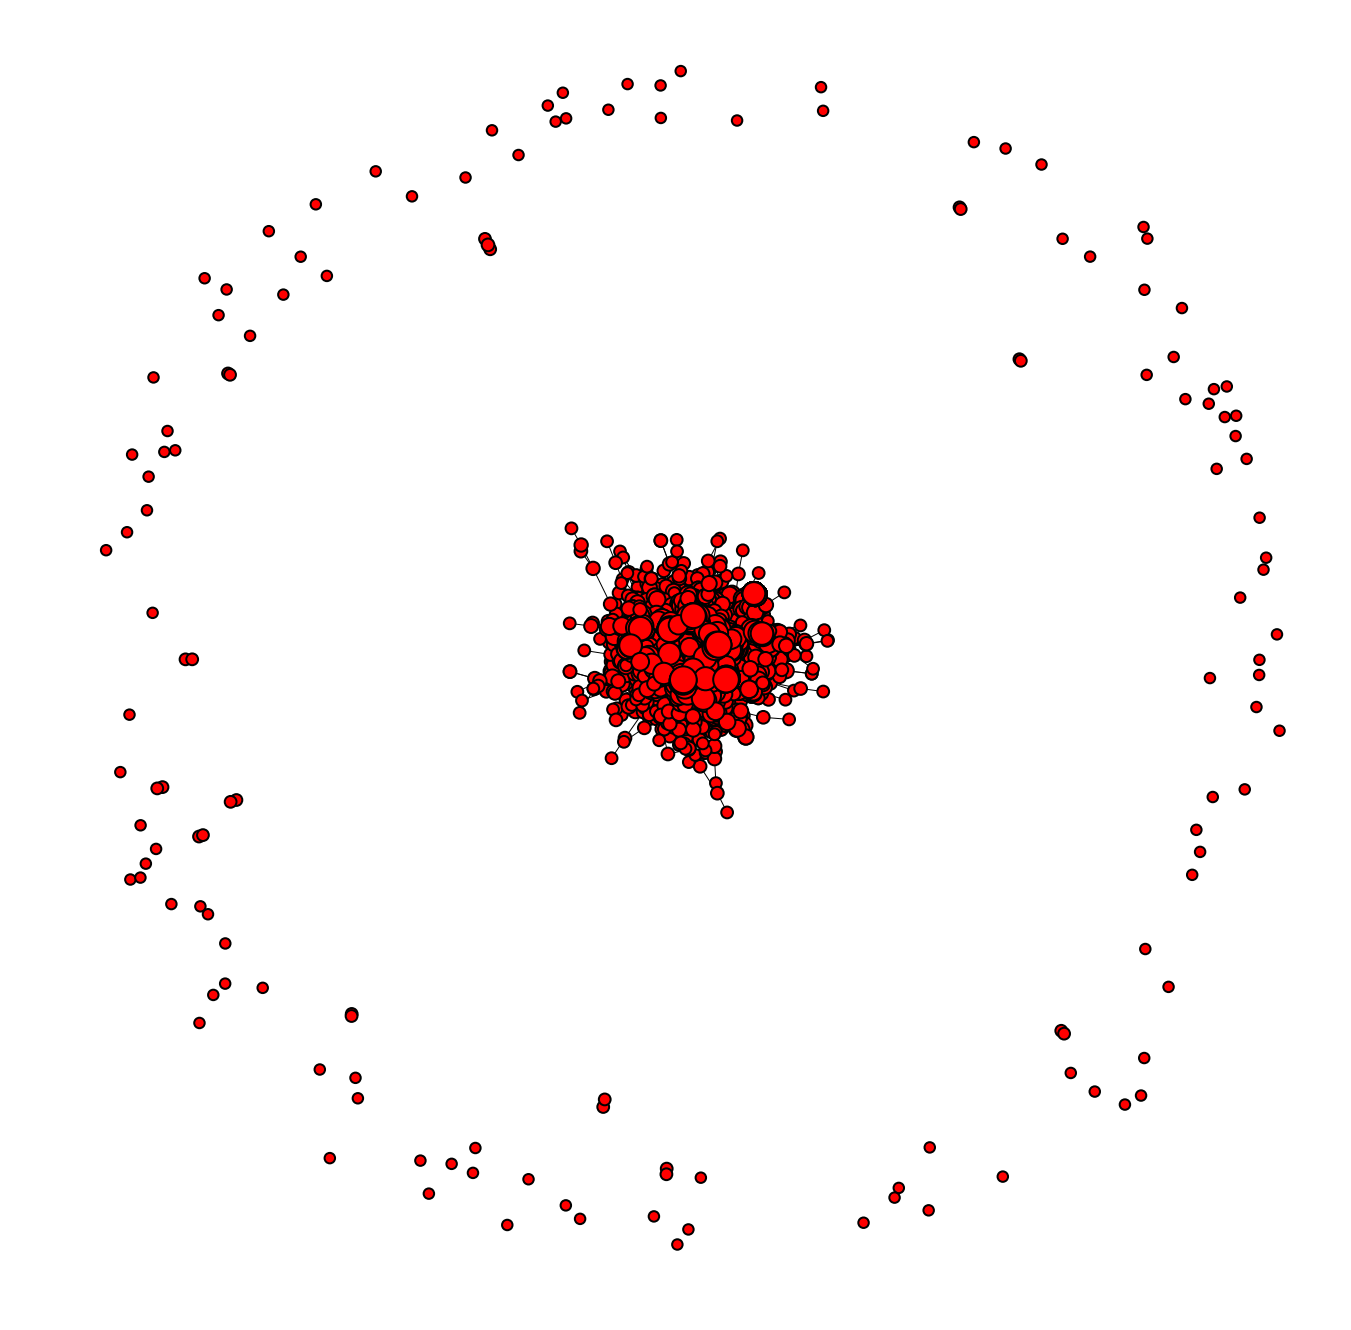

In [24]:
# visualize network
save_and_show_visualization(g, "politics.pdf")